In [73]:
from commonfunctions import *
from rle import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
from skimage.transform import resize as sk_resize
from skimage.filters import median, gaussian
from skimage.feature import canny
from skimage.filters import threshold_otsu
from collections import Counter
from skimage.transform import hough_line, hough_line_peaks, probabilistic_hough_line, rotate
from skimage import draw
from skimage.morphology import binary_opening, binary_closing, binary_dilation, binary_erosion, closing, opening, square
from skimage.feature import match_template
from skimage.measure import label, regionprops
from skimage.color import label2rgb
import matplotlib.patches as mpatches

In [75]:
def gray_img(img):
    gray = rgb2gray(img)
    if len(img.shape) == 3:
        gray = gray*255
    return gray

In [76]:
def otsu(img):
    blur = gaussian(img)
    otsu_bin = 255*(blur > threshold_otsu(blur))
    return (otsu_bin/255).astype(np.int32)

In [77]:
def calculate_thickness_spacing(rle, most_common):
    bw_patterns = [most_common_bw_pattern(col, most_common) for col in rle]
    bw_patterns = [x for x in bw_patterns if x]  # Filter empty patterns

    flattened = []
    for col in bw_patterns:
        flattened += col

    pair, count = Counter(flattened).most_common()[0]

    line_thickness = min(pair)
    line_spacing = max(pair)

    return line_thickness, line_spacing


In [78]:
def whitene(rle, vals, max_height):
    rlv = []
    for length, value in zip(rle, vals):
        if value == 0 and length < max_height:
            value = 1
        rlv.append((length, value))

    n_rle, n_vals = [], []
    count = 0
    for length, value in rlv:
        if value == 1:
            count = count + length
        else:
            if count > 0:
                n_rle.append(count)
                n_vals.append(1)
            
            count = 0
            n_rle.append(length)
            n_vals.append(0)
    if count > 0:
        n_rle.append(count)
        n_vals.append(1)

    return n_rle, n_vals

def remove_staff_lines(rle, vals, thickness, shape):
    n_rle, n_vals = [], []
    for i in range(len(rle)):
        rl, val = whitene(rle[i], vals[i], 2 * thickness)
        n_rle.append(rl)
        n_vals.append(val)

    return hv_decode(n_rle, n_vals, shape)

1


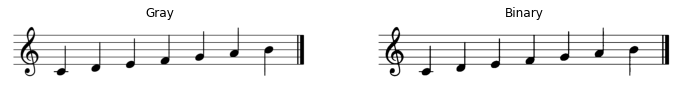

In [79]:
img = io.imread('dataset/03.PNG')
original = img.copy()
gray = gray_img(img)
bin_img = otsu(gray)
print(np.max(bin_img))
show_images([gray, bin_img], ['Gray', 'Binary'])

In [80]:
rle, vals = hv_rle(bin_img)
most_common = get_most_common(rle)
thickness, spacing = calculate_thickness_spacing(rle, most_common)
print(most_common, thickness, spacing)

32 3 29


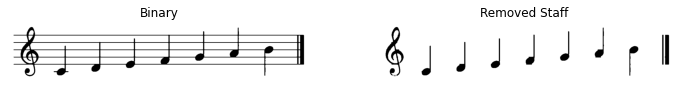

In [81]:
no_staff_img = remove_staff_lines(rle, vals, thickness, bin_img.shape)
show_images([bin_img, no_staff_img], ['Binary', 'Removed Staff'])

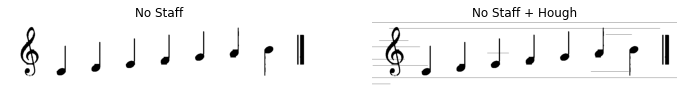

In [82]:
h_lines = probabilistic_hough_line(255-gray, threshold=gray.shape[1]//2)
lines = []
h_lines = sorted(h_lines, key=lambda l : l[0][1])

no_staff_lines = np.copy(no_staff_img)
for index, line in enumerate(h_lines):
    if index > 0 and (line[0][1] - lines[-1][0][1] < 0.9*spacing):
        pass
    else:
        p1, p2 = line
        x0, y0 = p1
        x1, y1 = p2
        lines.append(line)
        rr, cc = draw.line(x0, y0, x1, y0)
        # print(rr, cc)
        no_staff_lines[cc, rr] = 0

show_images([no_staff_img, no_staff_lines], ['No Staff', 'No Staff + Hough'])

In [83]:
end_of_staff = []
for index, line in enumerate(lines):
    if index > 0 and (line[0][1] - end_of_staff[-1][1] < 4*spacing):
        pass
    else:
        p1, p2 = line
        x0, y0 = p1
        x1, y1 = p2
        end_of_staff.append((x0, y0, x1, y1))

In [84]:
box_centers = []
spacing_between_staff_blocks = []
for i in range(len(end_of_staff)-1):
    spacing_between_staff_blocks.append(end_of_staff[i+1][1] - end_of_staff[i][1])
    if i % 2 == 0:
        offset = (end_of_staff[i+1][1] - end_of_staff[i][1])//2
        center = end_of_staff[i][1] + offset
        box_centers.append((center, offset))

max_staff_dist = np.max(spacing_between_staff_blocks)
max_margin = max_staff_dist // 2
margin = max_staff_dist // 10

In [85]:
end_points = []
regions_of_interest = []
regions_with_staff = []
img_with_bboxes = np.copy(gray)
for index, (center, offset) in enumerate(box_centers):
    y0 = int(center) - max_margin - offset + margin
    y1 = int(center) + max_margin + offset - margin
    end_points.append((y0, y1))

    rr, cc = draw.rectangle(start = (y0, 0), end = (y1, img_with_bboxes.shape[1]), shape=img_with_bboxes.shape)
    # io.imsave(f'blocks/region{index}.png', gray[y0:y1, 0:img_with_bboxes.shape[1]])
    regions_with_staff.append(gray[y0:y1, 0:img_with_bboxes.shape[1]])
    staff_block = no_staff_img[y0:y1, 0:img_with_bboxes.shape[1]]
    show_images([staff_block])
    regions_of_interest.append(opening(staff_block, np.ones((thickness, thickness))))
    img_with_bboxes[rr, cc] = 0

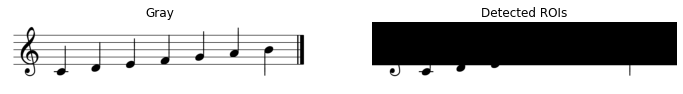

ROIs....


In [87]:
show_images([gray, img_with_bboxes], ['Gray', 'Detected ROIs'])
print('ROIs....')
if thickness % 2 == 0:
    thickness += 1
for staff_block in regions_of_interest:
    show_images([staff_block])
    # print(np.max(staff_block))

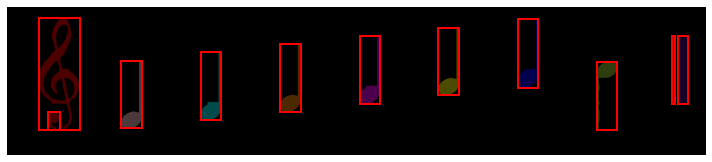

In [88]:
img = no_staff_img
img_with_staff = regions_with_staff[0]
primatives = []
thresh = threshold_otsu(img)
bw = closing(img <= thresh, square(3))
label_img = label(bw)
img_label_overlay = label2rgb(label_img, image=img, bg_label=0)
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(img_label_overlay)
for region in regionprops(label_img):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        primatives.append(img[minr:maxr, minc:maxc])
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
ax.set_axis_off()
plt.tight_layout()
plt.show()

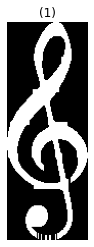

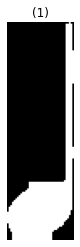

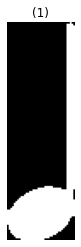

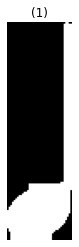

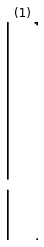

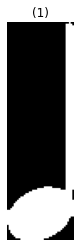

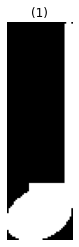

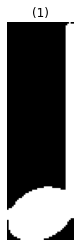

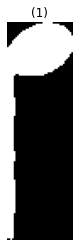

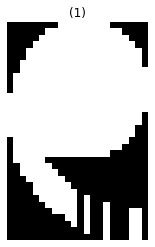

In [89]:
for i, prim in enumerate(primatives):
    prim = 255-255*prim
    io.imsave(f'prims_without_staff/prim{i}.png', prim.astype(np.uint8))
    show_images([prim])

In [90]:
lower, upper, samples, clef_thresh = 0.2, 1.0, 20, 0.7

clef_imgs = {
    "treble": [io.imread('dataset/treble_1.jpg'), io.imread('dataset/treble_2.jpg')],
    "bass": [io.imread('dataset/bass_1.jpg')],
    "clef": [io.imread('clef8.jpg')]
}

In [91]:
'''
An imutil function: https://github.com/jrosebr1/imutils/blob/master/imutils/convenience.py#L65
'''
def resize(image, width=None, height=None):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = sk_resize(image, dim)

    # return the resized image
    return resized

In [92]:
def match(imgs, templates, start, stop, samples, thresh):
    for img in imgs:
        # template = canny(template, low_threshold=50, high_threshold=200)
        for template in templates:
            template = gray_img(template)
            h, w = template.shape[:2]
            gimg = gray_img(img)
            found = None
            for scale in np.linspace(start, stop, samples)[::-1]:
                resized = resize(template, width=int(template.shape[1]*scale))
                r = template.shape[1] / float(resized.shape[1])

                if np.any(np.less(gimg.shape, template.shape)):
                    break

                # edged = canny(resized, low_threshold=50, high_threshold=100)
                result = match_template(gimg, resized)
                # result = np.where(result >= thresh)
                max_loc = np.unravel_index(np.argmax(np.copy(result)), result.shape)[::-1]
                # print(max_loc)
                max_val = result[max_loc[1], max_loc[0]]
                # print(max_val)
                if found is None or max_val > found[0]:
                    found = (max_val, max_loc, r)
            
            if found is not None:
                (_, max_loc, r) = found
                (minc, minr) = (int(max_loc[0]*r), int(max_loc[1]*r))
                (maxc, maxr) = (int((max_loc[0]+w)*r), int((max_loc[1]+h)*r))
                # print(minr, minc)
                # print(maxr, maxc)
                rr, cc = draw.rectangle(start=(minr, minc), end=(maxr, maxc), shape=img.shape)
                img[rr, cc] = 0
                # print(rr)
                # print(cc)
                show_images([template], ['Current Template'])
                show_images([img], ['Detected Image'])

In [93]:
def match2(imgs, templates, start, stop, samples, thresh):
    for img in imgs:
        out_img = np.copy(img)
        for template in templates:
            template = gray_img(template)
            img = gray_img(img)
            loc = False
            w, h = template.shape[::-1]
            for scale in np.linspace(start, stop, samples)[::-1]:
                resized = resize(template, width=int(template.shape[1]*scale))
                w, h = resized.shape[::-1]
                res = match_template(img, resized)
                loc = np.where(res >= thresh)
                if len(list(zip(*loc[::-1]))) > 0:
                    break

            if loc and len(list(zip(*loc[::-1]))) > 0:
                for pt in zip(*loc[::-1]):
                    (minc, minr) = pt
                    (maxc, maxr) = (minc+w, minr+h)
                    rr, cc = draw.rectangle(start=(minr, minc), end=(maxr, maxc), shape=img.shape)
                    out_img[rr, cc] = 0
                    show_images([out_img])

In [94]:

# for clef in clef_imgs:
#     match2(regions_with_staff, clef_imgs[clef], 0.2, 1.8, 50, 0.1)